In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
drive.mount('/content/gdriv')

Mounted at /content/gdriv


In [2]:
data_path = '/content/gdriv/My Drive/Colab Notebooks'
BCI = pd.read_csv(data_path+'/Data/BCI.csv')
BCI.head()

,date,BCI
0,1999-Mar-01,1000
1,1999-Mar-02,1009
2,1999-Mar-03,1014
3,1999-Mar-04,1013
4,1999-Mar-05,1005


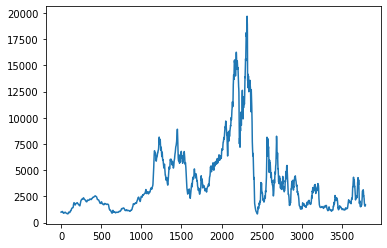

In [3]:
plt.plot(BCI['BCI'])
plt.show()

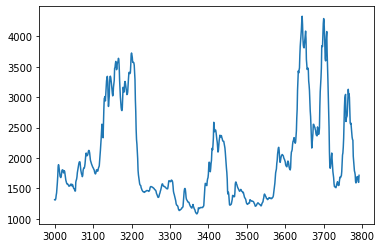

793


In [4]:
BCI = BCI.iloc[3000:,:]
plt.plot(BCI['BCI'])
plt.show()
sc = MinMaxScaler()
dt = sc.fit_transform(BCI.iloc[:,1:2])
print(len(dt))

In [5]:
train_size= int(len(dt) * 0.67)
test_size = len(dt) - train_size
train = np.array(dt[0:train_size])
test = np.array(dt[train_size:])
print(len(train))
print(len(test))

531
262


In [8]:
!pip install pmdarima
import pmdarima as pm
model = pm.auto_arima(train, error_action='ignore', trace=1,
                      suppress_warnings=True,
                      seasonal=True)

     |████████████████████████████████| 1.4 MB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 38.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3021.413, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2722.828, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3011.580, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2957.453, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2724.826, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3024.430, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3020.562, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3022.960, Time=0.52 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-3024.384, Time=0.28 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-3023.983, Time=0.87 s

In [9]:
# Forecast
n_periods = len(test)
pred, confint = model.predict(n_periods=n_periods, return_conf_int=True)
print(pred)

[0.051905   0.05075403 0.05068808 0.05063327 0.0505877  0.05054982
 0.05051833 0.05049215 0.05047039 0.0504523  0.05043727 0.05042477
 0.05041438 0.05040574 0.05039856 0.05039259 0.05038763 0.05038351
 0.05038008 0.05037723 0.05037486 0.05037289 0.05037125 0.05036989
 0.05036876 0.05036782 0.05036704 0.05036639 0.05036585 0.0503654
 0.05036503 0.05036472 0.05036446 0.05036425 0.05036407 0.05036392
 0.0503638  0.05036369 0.05036361 0.05036354 0.05036348 0.05036343
 0.05036339 0.05036336 0.05036333 0.0503633  0.05036328 0.05036327
 0.05036326 0.05036324 0.05036323 0.05036323 0.05036322 0.05036322
 0.05036321 0.05036321 0.0503632  0.0503632  0.0503632  0.0503632
 0.0503632  0.0503632  0.05036319 0.05036319 0.05036319 0.05036319
 0.05036319 0.05036319 0.05036319 0.05036319 0.05036319 0.05036319
 0.05036319 0.05036319 0.05036319 0.05036319 0.05036319 0.05036319
 0.05036319 0.05036319 0.05036319 0.05036319 0.05036319 0.05036319
 0.05036319 0.05036319 0.05036319 0.05036319 0.05036319 0.050363

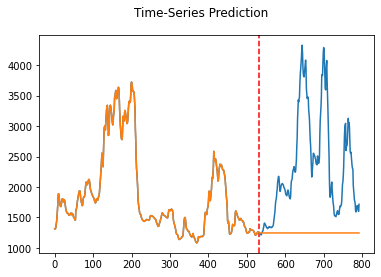

In [10]:
pred = pd.concat([pd.DataFrame(train),pd.DataFrame(pred)])
real = pd.concat([pd.DataFrame(train),pd.DataFrame(test)])
data_predict = pred.values
data_predict = sc.inverse_transform(data_predict)
real = sc.inverse_transform(real.values)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(real)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [11]:
def MSE(y,t) :
  return 0.5*np.sum((y-t)**2)

In [12]:
MSE(pred,real)

0    1.841699e+09
dtype: float64

In [13]:
dt = BCI.iloc[:,1:2].values

In [14]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [15]:
sc = MinMaxScaler()
dt = sc.fit_transform(dt)

seq_length = 90
x, y = sliding_windows(dt, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [16]:
class LSTM(nn.Module):

    def __init__(self, output, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.output = output
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [17]:
num_epochs = 2000
learning_rate = 0.02

input_size = 1
hidden_size = 2
num_layers = 1
output = 1

lstm = LSTM(output, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.15692
Epoch: 100, loss: 0.00111
Epoch: 200, loss: 0.00067
Epoch: 300, loss: 0.00047
Epoch: 400, loss: 0.00036
Epoch: 500, loss: 0.00032
Epoch: 600, loss: 0.00028
Epoch: 700, loss: 0.00026
Epoch: 800, loss: 0.00024
Epoch: 900, loss: 0.00023
Epoch: 1000, loss: 0.00022
Epoch: 1100, loss: 0.00021
Epoch: 1200, loss: 0.00020
Epoch: 1300, loss: 0.00020
Epoch: 1400, loss: 0.00020
Epoch: 1500, loss: 0.00020
Epoch: 1600, loss: 0.00020
Epoch: 1700, loss: 0.00019
Epoch: 1800, loss: 0.00019
Epoch: 1900, loss: 0.00019


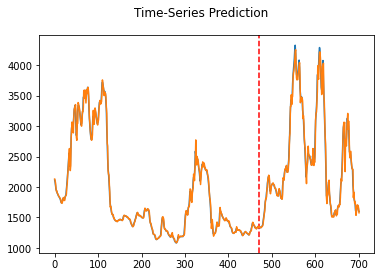

In [18]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [19]:
#LSTM MSE
MSE(data_predict,dataY_plot)

1461213.0